# Ill-posedness: An illustrative example

## 1D Inverse Heat Equation

An illustrative example of ill-posedness is the inversion for the initial condition for a one-dimensional heat equation.

Specifically, we consider a rod of length $L$, and let $u(x,t)$ denote the temperature of the rod at point $x$ and time $t$. 
We are interested in reconstructing the initial temperature profile $m(x) = u(x, 0)$ given some noisy measurements $d$ of the temperature profile at a later time $T$.

### Forward problem

Given
- the initial temperature profile $u(x,0) = m(x)$,
- the thermal diffusivity $k$,
- a prescribed temperature $u(0,t) = u(L,t) = 0$ at the ends of the rod,

solve the heat equation

$$
\left\{
\begin{array}{ll}
\frac{\partial u}{\partial t} - k \frac{\partial^2}{\partial x^2} u = 0 & \forall x\,\in\,(0, L)\; \forall t \in (0,T)\\
u(x, 0) = m(x) & \forall x \in [0,L] \\
u(0,t) = u(L,t) = 0 & \forall t \in (0, T],
\end{array}
\right.
$$

and observe the temperature at the final time $T$:

$$ \mathcal{F}(m) = u(x, T). $$

#### Analytical solution to the forward problem
Verify that if

$$ m(x) = \sin\left(i\, \frac{\pi}{L} x \right), \quad i = 1,2,3, \ldots ,$$

then

$$ u(x,t) = e^{ -k\left(i\, \frac{\pi}{L} \right)^2 t} \sin\left(i\,\frac{\pi}{L} x \right) $$

is the unique solution to the heat equation.

### Inverse problem

Given the forward model $\mathcal{F}$ and a noisy measurement $d$ of the temperature profile at time $T$, find the initial temperature profile $m$ such that

$$ \mathcal{F}(m) = d. $$

### Ill-posedness of the inverse problem

Consider a perturbation

$$ \delta m(x) = \varepsilon \sin\left(i \, \frac{\pi}{L} x \right), $$

where $\varepsilon > 0$ and $i = 1, 2, 3, \ldots$.

Then, by linearity of the forward model $\mathcal{F}$, the corresponding perturbation $\delta d(x) = \mathcal{F}(m + \delta m) - \mathcal{F}(m)$ is

$$ \delta d(x) = \varepsilon\, e^{ -k\left(i \, \frac{\pi}{L}\right)^2 T} \sin\left(i \, \frac{\pi}{L} x \right),$$

which converges to zero as $i \rightarrow +\infty$.

Hence the ratio between $\delta m$ and $\delta d$ can become arbitrary large, which shows that the stability requirement for well-posedness can not be satisfied.

### Discretization

To discretize the problem, we use finite differences in space and Implicit Euler in time.

#### Semidiscretization in space
We divide the $[0, L]$ interval in $n_x$ subintervals of the same lenght $h = \frac{L}{n_x}$, and we denote with $u_j(t) := u( jh, t)$ the value of the temperature at point $x_j = jh$ and time $t$.

We then use a centered finite difference approximation of the second derivative in space and write

$$ \frac{\partial u_j(t)}{\partial t} - k \frac{u_{j-1}(t) - 2u_j(t) + u_{j+1}(t)}{h^2} \quad \text{for } j=1,2,\ldots,n_x-1,$$

with the boundary condition $u_0(t) = u_{n_x}(t) = 0$.

We let $n = n_x-1$ be the number of discretization points in the interior of the interval $[0, L]$, and let 

$$ \mathbf{u}(t) = \begin{bmatrix}u_1(t)\\u_2(t)\\ \ldots\\ u_{n_x-1}(t) \end{bmatrix} \in \mathbb{R}^n $$

be the vector collecting the values of the temperature $u(x,t)$ at the points $x_j = j\,h$ with $j=1,\ldots,n_x-1$.

We then write the system of ordinary differential equations (ODEs):
$$ \frac{\partial}{\partial t} \mathbf{u}(t) + K \mathbf{u}(t) = 0,$$
where $K \in \mathbb{R}^{n \times n}$ is the tridiagonal matrix given by

$$ K = \frac{k}{h^2}\begin{bmatrix}  2 & -1 &       &        &        &    \\
                                    -1 &  2 & -1    &        &        &    \\
                                       & -1 &  2    & -1     &        &    \\
                                       &    &\ldots & \ldots & \ldots &    \\
                                       &    &       & -1     &     2  & -1 \\ 
                                       &    &       &        &     -1 & 2  \\
                     \end{bmatrix}.$$
                     
#### Time discretization
We subdivide the time interval $(0, T]$ in $n_t$ time step of size $\Delta t = \frac{T}{n_t}$.
By letting $\mathbf{u}^{(i)} = \mathbf{u}(i\,\Delta t)$ denote the discretized temperature profile at time $t_i = i\,\Delta t$, the Implicit Euler scheme reads

$$ \frac{\mathbf{u}^{(i+1)} - \mathbf{u}^{(i)}}{\Delta t} + K\mathbf{u}^{(i+1)} = 0, \quad \text{for } i=0,1,\ldots, n_t-1.$$

After simple algebraic manipulations and exploiting the initial condition $u(x,0) = m(x)$, we then obtain

$$
\left\{
\begin{array}
\mathbf{u}^{(0)} = \mathbf{m} \\
\mathbf{u}^{(i+1)} = \left( I + \Delta t\, K\right)^{-1} \mathbf{u}^{(i)},
\end{array}
\right.
$$

or equivalently

$$ \mathbf{u}^{(i)} = \left( I + \Delta t\, K\right)^{-i} \mathbf{m}.$$

In the code below, the function `assembleMatrix` generates the finite difference matrix $\left( I + \Delta t\, K \right)$ and the function `solveFwd` evaluates the forward model

$$ F\, \mathbf{m} = \left( I + \Delta t\, K\right)^{-n_t}\, \mathbf{m}. $$

In [1]:
from __future__ import print_function, absolute_import, division

import warnings
warnings.filterwarnings('ignore')

import numpy as np
import scipy.sparse as sp
import scipy.sparse.linalg as la
import matplotlib.pyplot as plt
%matplotlib inline

SMALL_SIZE = 20
MEDIUM_SIZE = 30
BIGGER_SIZE = 40
plt.rc('font', size=SMALL_SIZE)          
plt.rc('axes', titlesize=SMALL_SIZE)     
plt.rc('axes', labelsize=MEDIUM_SIZE)    
plt.rc('xtick', labelsize=SMALL_SIZE)    
plt.rc('ytick', labelsize=SMALL_SIZE)    
plt.rc('legend', fontsize=SMALL_SIZE)    
plt.rc('figure', titlesize=BIGGER_SIZE)  

def plot(f, style, **kwargs):
    x = np.linspace(0., L, nx+1)
    f_plot = np.zeros_like(x)
    f_plot[1:-1] = f
    plt.plot(x,f_plot, style, **kwargs)
    
def assembleMatrix(k, h, dt, n):
    """
    The function assembles the matrix (I + \delta_t K)
    Here:
    - k is the thermal diffusivity coefficient
    - h is the spacial discretization size
    - dt is the temporal discretization size
    - n is the number of subintervals
    """
    # To assemble matrix K, first create 3 diagonals
    # and then call scipy function `spdiags`,
    # which creates a sparse matrix given the diagonals
    diagonals = np.zeros((3, n))   # 3 diagonals
    diagonals[0,:] = -1.0/h**2
    diagonals[1,:] =  2.0/h**2
    diagonals[2,:] = -1.0/h**2
    K = k*sp.spdiags(diagonals, [-1,0,1], n,n)
    
    # M holds an identity matrix,
    # which is assembled similarly to K,
    # but by specifying only main diagonal of ones
    M = sp.spdiags(np.ones(n), 0, n,n)
    
    return M + dt*K
    

def solveFwd(m, k, h, dt, n, nt):
    """
    The function computes the temperature at the final time, u(T),
    for a given initial condition m.
    Here:
    - m is the initial condition
    - k is the thermal diffusivity coefficient
    - h is the spacial discretization size
    - dt is the temporal discretization size
    - n is the number of subintervals 
    - nt is the number of time steps
    """
    
    
    # Assemble the matrix (note, that it is
    # constant, so we can use it for all time steps)
    A = assembleMatrix(k, h, dt, n)
    
    # u_old holds the most recent known value of u
    u_old = m.copy()
    
    # solve the system for nt time steps
    for i in np.arange(nt):
        # scipy function `spsolve` solves 
        # sparse linear system
        u = la.spsolve(A, u_old)
        u_old[:] = u
        
    return u        

### A naive solution to the inverse problem

If $\mathcal{F}$ is invertible a naive solution to the inverse problem $\mathcal{F} m = d$ is simply to set

$$ m = \mathcal{F}^{-1} d. $$

The function `naiveSolveInv` computes the solution of the discretized inverse problem $\mathbf{m} = F^{-1} \mathbf{d}$ as

$$ \mathbf{m} = \left( I + \Delta t\,K\right)^{n_t} \mathbf{d}. $$

The code below shows that:
- for a very coarse mesh (`nx = 20`) and no measurement noise (`noise_std_dev = 0.0`) the naive solution is quite good
- for a finer mesh (`nx = 100`) and/or even small measurement noise (`noise_std_dev = 1e-4`) the naive solution is garbage

In [2]:
def naiveSolveInv(d, k, h, dt, n, nt):
    """
    Solves the inverse problem by applying 
    the matrix (I + \delta_t K) n_t times
    """
    A = assembleMatrix(k, h, dt, n)
    
    p_i = d.copy()
    for i in np.arange(nt):
        p = A*p_i
        p_i[:] = p
        
    return p

In [3]:
# physical parameters
T = 1.0
L = 1.0
k = 0.01

def showInvresionResults(nx, nt, noise_std_dev, T, L, k):
    # utility function to show inversion results
    
    
    h = L/float(nx)
    dt = T/float(nt)

    x = np.linspace(0.+h, L-h, nx-1) #place nx-1 equispace point in the interior of [0,L] interval
    m_true = 0.5 - np.abs(x-0.5)
    u_true = solveFwd(m_true, k, h, dt, nx-1, nt)

    d = u_true + noise_std_dev*np.random.randn(u_true.shape[0])

    m = naiveSolveInv(d, k, h, dt, nx-1, nt)

    plt.figure(figsize=(20,10))
    plt.subplot(1,2,1)
    plot(m_true, "-.b", label = 'm_true')
    plot(m, "-r", label = 'm')
    plt.legend()
    plt.title("Initial temperature profile")
    plt.subplot(1,2,2)
    plot(u_true, "-b", label = 'u(T)')
    plot(d, "og", label = 'd')
    plt.legend()
    plt.title("Temperature solution at final moment")
    plt.show()

__Very coarse mesh and no measurement noise__

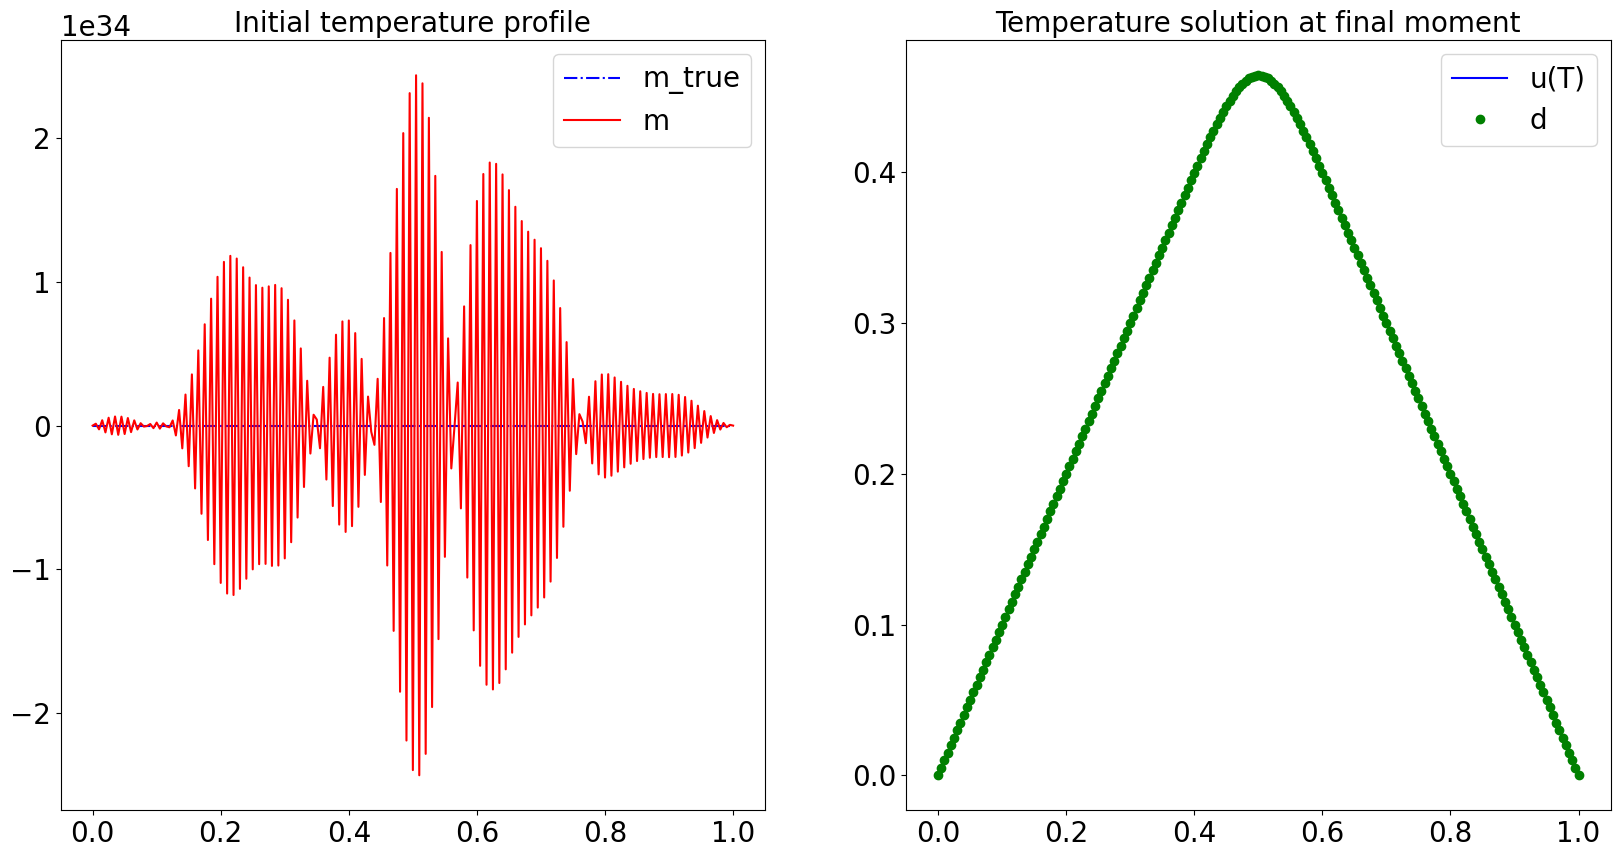

In [4]:
T = 1.0
L = 1.0
k = 0.001
nx = 200
nt = 200
noise_std_dev = 0.000


showInvresionResults(nx, nt, noise_std_dev, T, L, k)

__Very coarse mesh and small measurement noise__

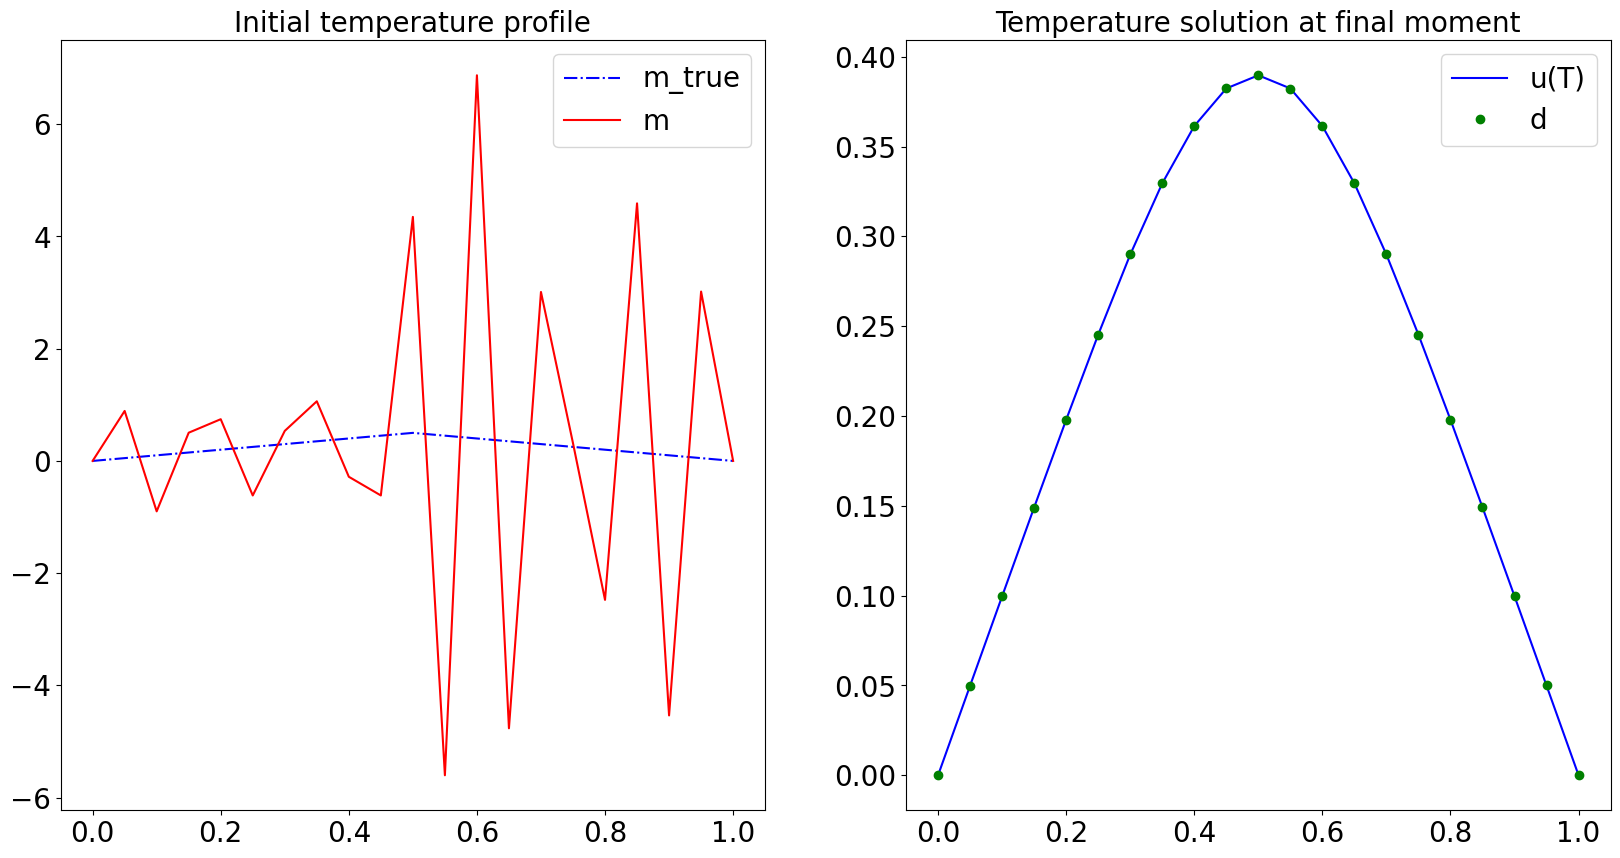

In [5]:
T = 1.0
L = 1.0
k = 0.01
nx = 20
nt = 20
noise_std_dev = 1.e-4

showInvresionResults(nx, nt, noise_std_dev, T, L, k)

__Fine mesh and no measurement noise__

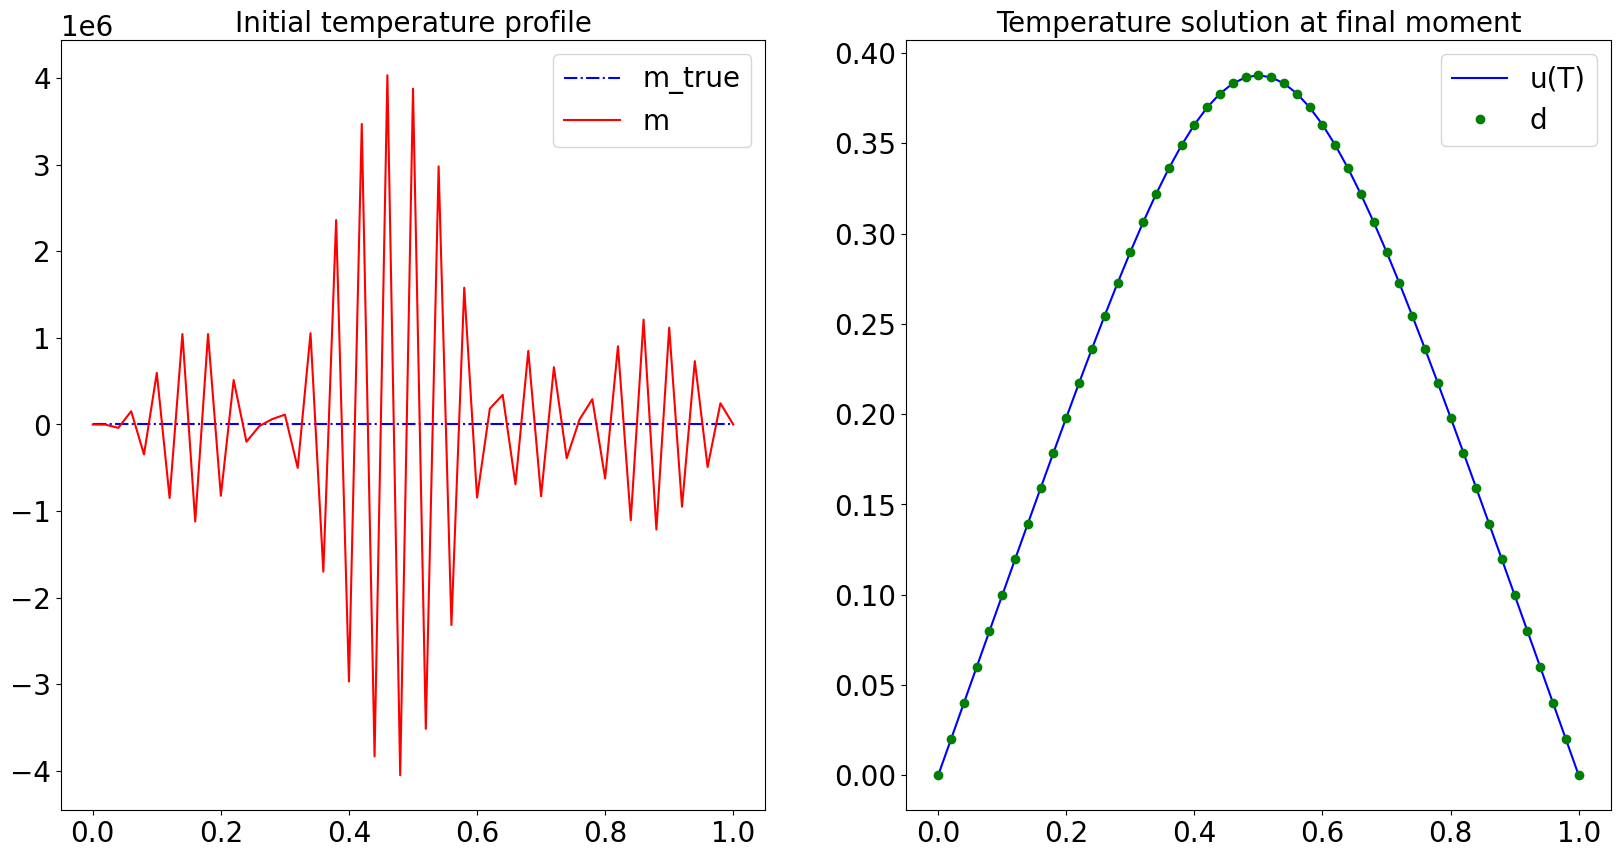

In [6]:
T = 1.0
L = 1.0
k = 0.01
nx = 50
nt = 50
noise_std_dev = 0.

showInvresionResults(nx, nt, noise_std_dev, T, L, k)

__Fine mesh and small measurement noise__

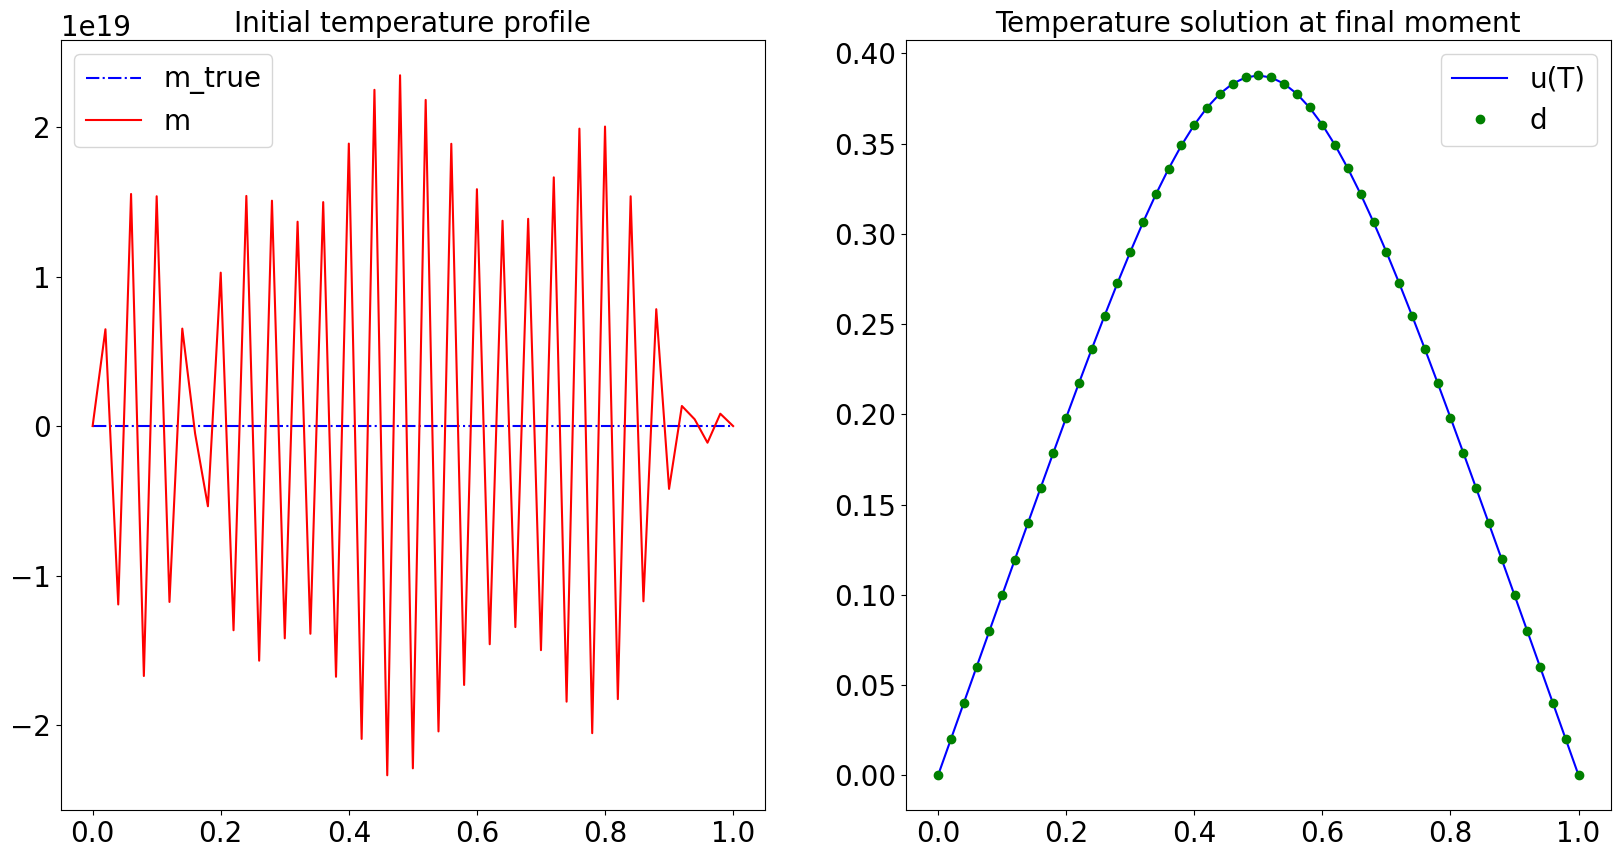

In [7]:
T = 1.0
L = 1.0
k = 0.01
nx = 50
nt = 50
noise_std_dev = 1.e-4

showInvresionResults(nx, nt, noise_std_dev, T, L, k)

### Why does the naive solution fail?

#### Spectral property of the parameter to observable map

Let $v_i = \sqrt{\frac{2}{L}} \sin\left( i \, \frac{\pi}{L} x \right)$ with $i=1,2,3, \ldots$, then we have that

$$ \mathcal{F} v_i = \lambda_i v_i, \quad \text{where the eigenvalues } \lambda_i = e^{-kT\left(\frac{\pi}{L} i \right)^2}. $$

**Note**:
- Large eigenvalues $\lambda_i$ corresponds to smooth eigenfunctions $v_i$;
- Small eigenvalues $\lambda_i$ corresponds to oscillatory eigenfuctions $v_i$.

The figure below shows that the eigenvalues $\lambda_i$ of the continuous parameter to obervable map $\mathcal{F}$ decays extremely (exponentially) fast.

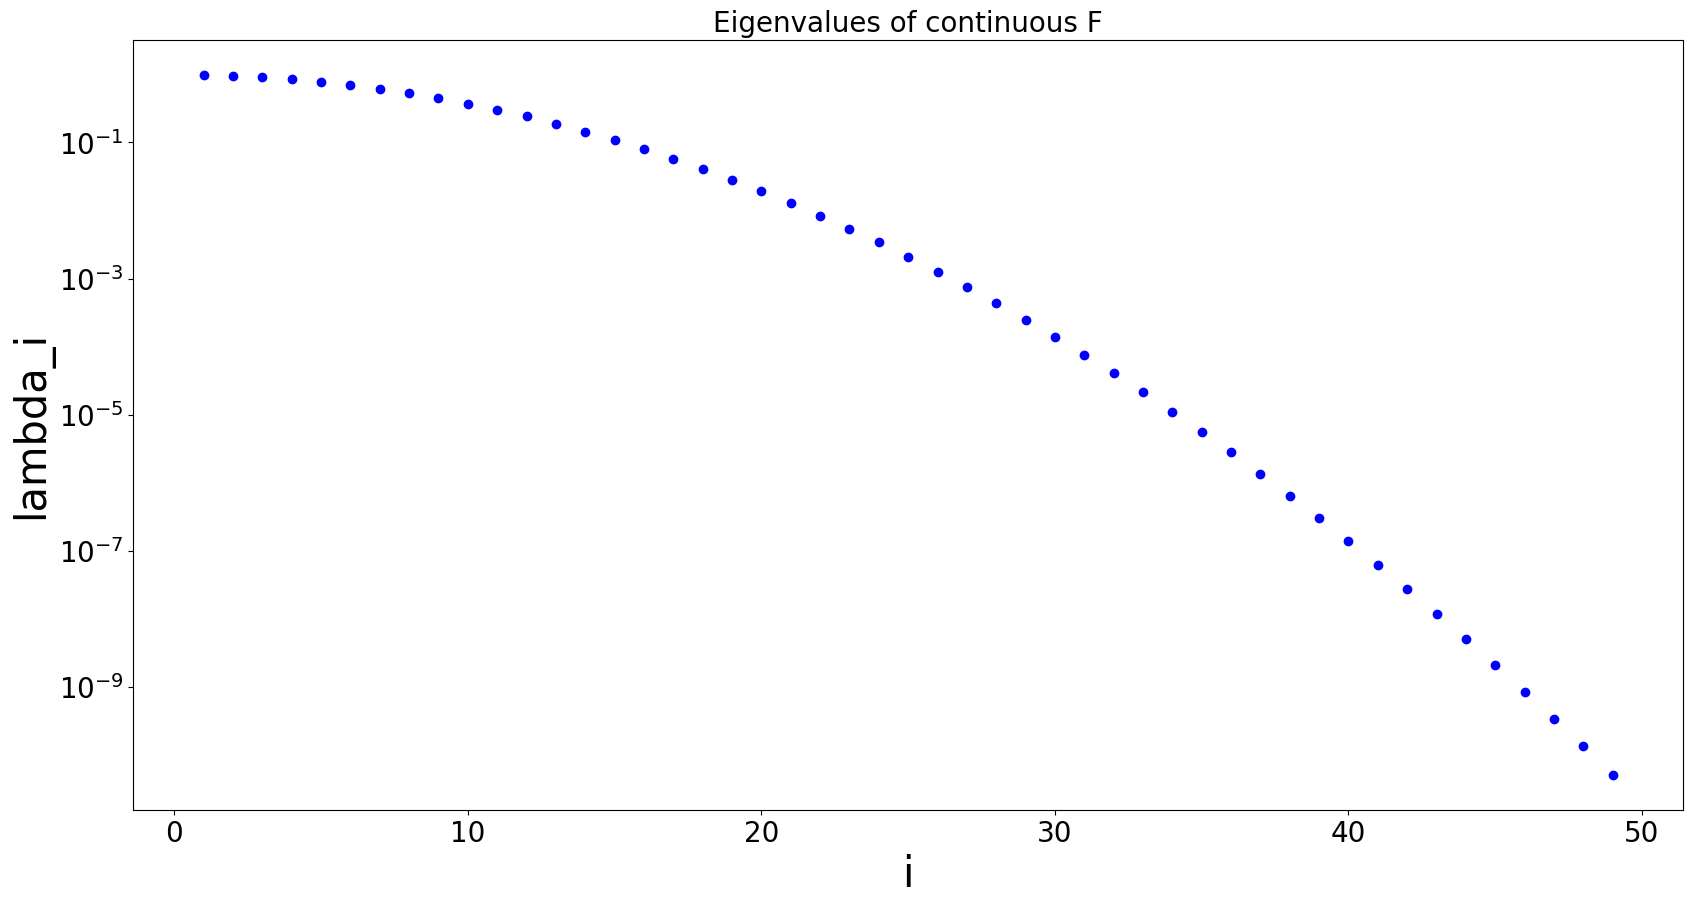

In [8]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

T = 1.0
L = 1.0
k = 0.001

i = np.arange(1,50)
lambdas = np.exp(-k*T*np.power(np.pi/L*i,2))

plt.figure(figsize=(20,10))
plt.semilogy(i, lambdas, 'ob')
plt.xlabel('i')
plt.ylabel('lambda_i')
plt.title("Eigenvalues of continuous F")
plt.show()

  In a similar way, the figure below show the eigenvalues of the discrete parameter to observable map $F$: their fast decay means that $F$ is extremely ill conditioned.

In the code below we assemble the matrix $F$ column-by-column, by computing its actions on the canonical vectors 
$$\mathbf{m}_i = \begin{bmatrix} 0 \\ \ldots \\ 0\\ 1 \\ 0\\ \ldots \\0 \end{bmatrix}, \quad i = 1,\ldots,n,$$
where the $i$th entry is the only non-zero component of $\mathbf{m}_i$.

> **Disclaimer**: $F$ is a large dense implicitly defined operator and should never be built explicitly for a real problem (since it would require $\mathcal{O}(n)$ evaluations of the forward problem and $\mathcal{O}( n^2)$ storage); instead --- as you will learn later this semester --- scalable algorithms for the solution of the inverse problem only require the ability to compute the action of $F$ on a few given directions $\mathbf{m}$.

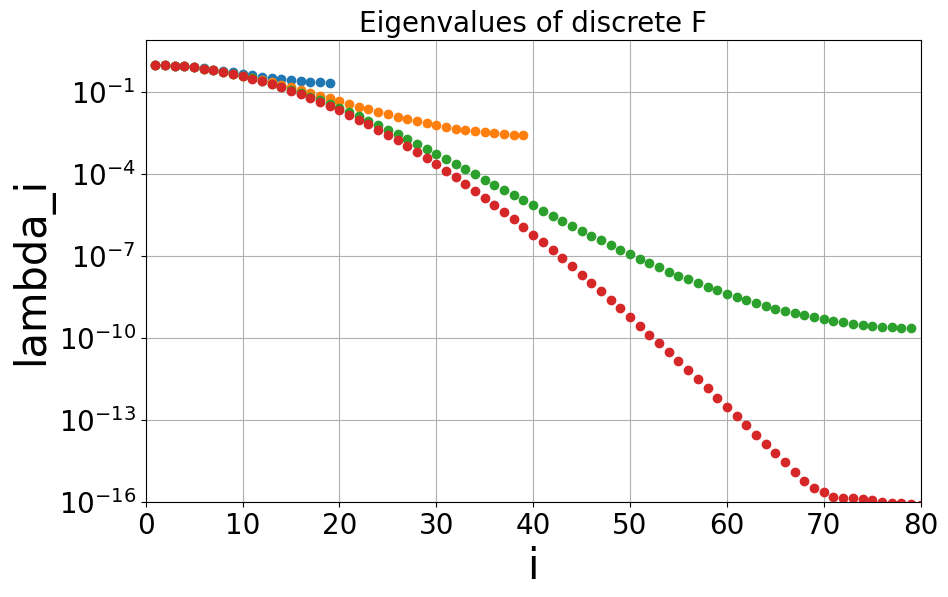

In [ ]:
def computeEigendecomposition(k, n, nt):
    h = L/float(nx)
    dt = T/float(nt)
    ## Compute F as a dense matrix
    F = np.zeros((n,n))
    m_i = np.zeros(n)
    
    for i in np.arange(n):
        m_i[i] = 1.0
        F[:,i] = solveFwd(m_i, k, h, dt, n, nt)
        m_i[i] = 0.0
    
    ## solve the eigenvalue problem
    lmbda, U = np.linalg.eigh(F)
    ## sort eigenpairs in decreasing order
    lmbda[:] = lmbda[::-1]
    lmbda[lmbda < 0.] = 0.0
    U[:] = U[:,::-1]
    
    return lmbda, U 

"""
Below you can vary the discretization parameters nx and nt in order to see their effect 
on the spectrum (and compare with the continuous spectrum above)
"""
"""
nx = 40
nt = 100
## Compute eigenvector and eigenvalues of the discretized forward operator
lmbda, U = computeEigendecomposition(k, nx-1, nt)

plt.figure(figsize=(20,10))
plt.semilogy(lmbda, 'ob')
plt.xlabel('i')
plt.ylabel('lambda_i')
plt.title("Eigenvalues of discrete F")
plt.show()
"""


discretizations = [(20, 20), (40, 40), (80, 80), (160, 160)]
plt.figure(figsize=(10, 6))
for nx, nt in discretizations:
    lmbda, U = computeEigendecomposition(k, nx-1, nt)
    # plt.figure(figsize=(20,10))
    plt.semilogy(range(1, len(lmbda)+1),lmbda, 'o')
plt.xlabel('i')
plt.ylabel('lambda_i')
plt.title("Eigenvalues of discrete F")
plt.yscale('log')
plt.ylim(10**(-16))
plt.xlim(0,80)
plt.grid()
plt.show()


In [10]:
print(lmbda)

[0.99018444 0.96137613 0.91541553 0.8551344  0.78404465 0.70597723
 0.62472536 0.54373912 0.46590352 0.3934138  0.32774444 0.26969516
 0.21949009 0.1769051  0.14140107 0.11224691 0.08862223 0.06969558
 0.05467841 0.04285784 0.03361257 0.02641661 0.020835   0.01651482
 0.01317417 0.01059077 0.00859106 0.00704071 0.00583635 0.00489885
 0.00416788 0.00359756 0.00315311 0.00280823 0.00254317 0.00234321
 0.00219756 0.00209856 0.0020411 ]


#### Informed and uninformed modes

The functions $v_i$ ($i=1,2,3, \ldots$) form an orthonormal basis of $L^2([0,1])$. 

That is, every function $f \in L^2([0,1])$ can be written as

$$ f = \sum_{i=1}^\infty \alpha_i v_i, \text{ where } \alpha_i = \int_0^1 f v_i dx.$$

Consider now the noisy problem

$$ d = \mathcal{F}\,m_{\rm true} + \eta, $$

where
- $d$ is the data (noisy measurements)
- $\eta$ is the noise: $\eta(x) = \sum_{n=1}^\infty \eta_n v_n(x)$
- $m_{\rm true}$ is the true value of the parameter that generated the data
- $\mathcal{F}$ is the forward heat equation

Then, the naive solution to the inverse problem $\mathcal{F}m = d$ is

$$ m = \mathcal{F}^{-1}d = \mathcal{F}^{-1}\left( \mathcal{F}\,m_{\rm true} + \eta \right) = m_{\rm true} + \mathcal{F}^{-1} \eta = m_{\rm true} + \mathcal{F}^{-1} \sum_{i=1}^{\infty} \eta_i v_i = m_{\rm true} +  \sum_{i=1}^{\infty} \frac{\eta_i}{\lambda_i} v_i. $$

If the coefficients $\eta_i = \int_0^1 \eta(x) \, v_i(x) \, dx$ do not decay sufficiently fast with respect to the eigenvalues $\lambda_i$, then the naive solution is unstable.

This implies that oscillatory components can not reliably be reconstructed from noisy data since they correspond to small eigenvalues.

